<a href="https://colab.research.google.com/github/AriSalassa/vision-por-computadora-2/blob/master/3/VPC2_Clase_3_Tarea_3co2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()

'/content'

In [ ]:
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/ColabNotebooks/Kaggle'

In [ ]:
!pip install kaggle

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/drive/MyDrive/ColabNotebooks/Kaggle')
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

['kaggle.json']

In [ ]:
!kaggle datasets download -d rishabkoul1/vechicle-dataset

 81% 5.00M/6.21M [00:00<00:00, 14.3MB/s]
100% 6.21M/6.21M [00:00<00:00, 15.7MB/s]


In [ ]:
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

['kaggle.json', 'vechicle-dataset.zip']

In [ ]:
 !unzip /content/drive/MyDrive/ColabNotebooks/Kaggle/vechicle-dataset.zip -d /content/sample_data

Archive:  /content/drive/MyDrive/ColabNotebooks/Kaggle/vechicle-dataset.zip
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/bike/Z (2).jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/bike/Z (3).jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/bike/Z (4).jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/bike/Z (5).jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/bike/Z (6).jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/bike/Z (7).jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/bike/Z.jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/boat/P8H6OFO4HGgGVcAAAAASUVORK5CYII_.png  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/boat/Z (1).jpg  
  inflating: /content/sample_data/vechicle_with_train/vechicles/test/boat/Z (2).jpg  
  inflating: /content/sample_data/vechicle

### Carga de datos con ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "/content/sample_data/vechicle_with_train/vechicles/train"
test_path = "/content/sample_data/vechicle_with_train/vechicles/test"

IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255)

valid_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    target_size=IMG_SIZE,
                                                    batch_size=32)

valid_generator = valid_datagen.flow_from_directory(directory=test_path,
                                                    target_size=IMG_SIZE,
                                                    batch_size=32)

Found 528 images belonging to 10 classes.
Found 74 images belonging to 10 classes.


#### Visualización de datos

In [ ]:
vehicles_classes = os.listdir(train_path)
vehicles_classes

['scooty',
 'plane',
 'truck',
 'boat',
 'helicopter',
 'cycle',
 'bus',
 'train',
 'bike',
 'car']

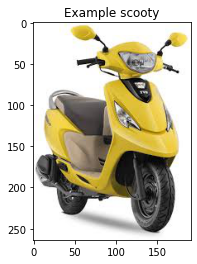

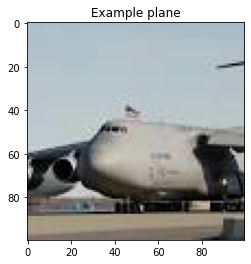

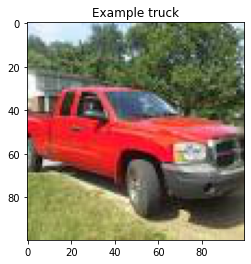

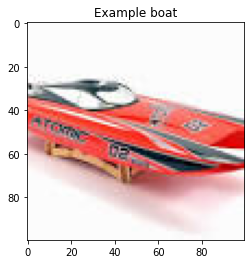

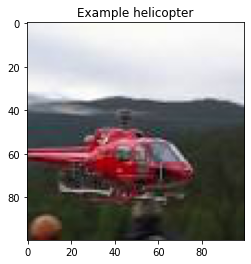

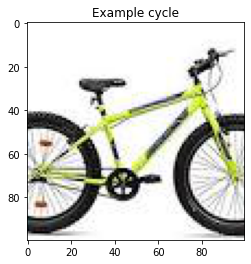

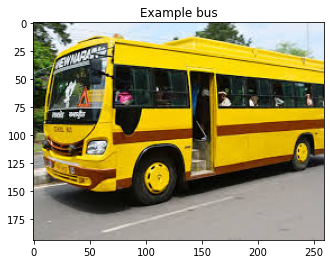

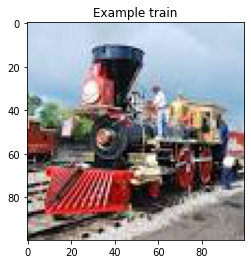

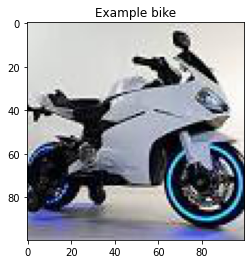

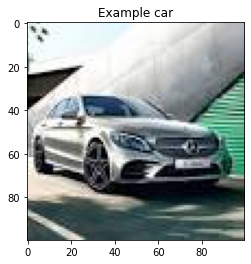

In [ ]:
for c in vehicles_classes:
  p = f"{train_path}/{c}"
  files = os.listdir(p)
  img = plt.imread(f"{p}/{files[2]}")
  fig, rows = plt.subplots(nrows=1, ncols=1)
  plt.imshow(img)
  plt.title(f"Example {c}")

### Carga de modelo base y entrenamiento últimas capas

#### VGG 16

In [ ]:
vgg_base = tf.keras.applications.VGG16(weights='imagenet',
                                       include_top=False,
                                       input_shape=(224, 224, 3))

vgg_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
vgg_base.trainable = False

In [ ]:
model = tf.keras.Sequential()

model.add(vgg_base)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1028, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),    
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=valid_generator)

Epoch 1/10
17/17 [==============================] - 315s 19s/step - loss: 2.0601 - categorical_accuracy: 0.2936 - val_loss: 1.8548 - val_categorical_accuracy: 0.3514
Epoch 2/10
17/17 [==============================] - 313s 18s/step - loss: 1.5788 - categorical_accuracy: 0.5076 - val_loss: 1.5440 - val_categorical_accuracy: 0.5135
Epoch 3/10
17/17 [==============================] - 315s 19s/step - loss: 1.3065 - categorical_accuracy: 0.6402 - val_loss: 1.3779 - val_categorical_accuracy: 0.5541
Epoch 4/10
17/17 [==============================] - 314s 19s/step - loss: 1.1203 - categorical_accuracy: 0.6648 - val_loss: 1.2159 - val_categorical_accuracy: 0.5676
Epoch 5/10
17/17 [==============================] - 314s 19s/step - loss: 0.9871 - categorical_accuracy: 0.7216 - val_loss: 1.1314 - val_categorical_accuracy: 0.5676
Epoch 6/10
17/17 [==============================] - 312s 18s/step - loss: 0.8255 - categorical_accuracy: 0.7822 - val_loss: 1.0486 - val_categorical_accuracy: 0.6892
Epoc

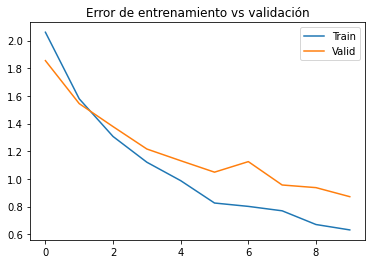

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

#### Otra red

In [ ]:
resnet50_base = tf.keras.applications.ResNet50V2(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224, 224, 3))

resnet50_base.summary()

94683136/94668760 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
resnet50_base.trainable = False

In [ ]:
model_res = tf.keras.Sequential()

model_res.add(resnet50_base)

model_res.add(tf.keras.layers.Flatten())
model_res.add(tf.keras.layers.Dense(1028, activation='relu'))
model_res.add(tf.keras.layers.Dense(256, activation='relu'))
model_res.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model_res.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),    
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history_res = model_res.fit(train_generator,
                    epochs=5,
                    validation_data=valid_generator)

Epoch 1/5
17/17 [==============================] - 122s 7s/step - loss: 0.1064 - categorical_accuracy: 0.9754 - val_loss: 0.7105 - val_categorical_accuracy: 0.8243
Epoch 2/5
17/17 [==============================] - 106s 6s/step - loss: 0.0549 - categorical_accuracy: 0.9792 - val_loss: 0.5601 - val_categorical_accuracy: 0.8514
Epoch 3/5
17/17 [==============================] - 115s 7s/step - loss: 0.0696 - categorical_accuracy: 0.9867 - val_loss: 0.8384 - val_categorical_accuracy: 0.8243
Epoch 4/5
17/17 [==============================] - 106s 6s/step - loss: 0.0402 - categorical_accuracy: 0.9867 - val_loss: 0.5370 - val_categorical_accuracy: 0.8243
Epoch 5/5
17/17 [==============================] - 115s 7s/step - loss: 0.1051 - categorical_accuracy: 0.9811 - val_loss: 0.7131 - val_categorical_accuracy: 0.8514


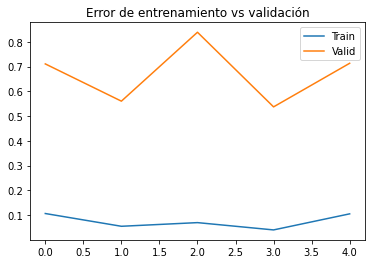

In [ ]:
plt.plot(history_res.history["loss"])
plt.plot(history_res.history["val_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()